In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
temp_data_train = pd.read_csv('../Data/train_data.csv')
temp_data_test = pd.read_csv('../Data/test_data.csv')
# Convert the 'date' column to datetime
temp_data_train['date'] = pd.to_datetime(temp_data_train['date'])
temp_data_test['date'] = pd.to_datetime(temp_data_test['date'])

T_actual_train = temp_data_train['mean'].to_numpy()
T_actual_test = temp_data_test['mean'].to_numpy()

temp_data_test.head()

,date,mean,max,min
0,2024-04-01,10.33,20.39,3.61
1,2024-04-02,13.22,24.22,4.50
2,2024-04-03,14.72,24.39,3.72
3,2024-04-04,12.28,24.22,5.11
4,2024-04-05,8.22,16.89,3.50


Linear and Seasonal forecast

In [3]:
# Forecast horizon
forecast_end = 365

# Create empty DataFrame with placeholders
forecast_df = pd.DataFrame(index=np.arange(forecast_end), columns=['date', 't', 'trend', 'seasonal', 'forecast', 'actual'])

# Assign actual values (truncate if necessary)
forecast_df['actual'] = T_actual_test[:forecast_end]

# Set date range starting from first test date
start_date = temp_data_test['date'].iloc[0]
date_range = pd.date_range(start=start_date, periods=forecast_end)
forecast_df['date'] = date_range

# Set time index t continuing from training period
start_t = len(temp_data_train)  # assuming daily data with t = 0,1,...,N
forecast_df['t'] = np.arange(start_t + 1, start_t + forecast_end + 1)

# trend model
intercept, slope = 16.72181, 0.00002
forecast_df['trend'] =  slope * forecast_df['t']

# View the first few rows
print(forecast_df.head())

        date      t    trend seasonal forecast  actual
0 2024-04-01  33287  0.66574      NaN      NaN   10.33
1 2024-04-02  33288  0.66576      NaN      NaN   13.22
2 2024-04-03  33289  0.66578      NaN      NaN   14.72
3 2024-04-04  33290  0.66580      NaN      NaN   12.28
4 2024-04-05  33291  0.66582      NaN      NaN    8.22


In [4]:
def forecast_seasonal(t, fitted_params):
    """
    Forecast seasonal component using fitted sinusoidal model
    
    Parameters:
    t_future: array-like, future time points to forecast
    fitted_params: list or array containing [a1, phi1, a2, phi2, a3, phi3, a4, phi4]
    
    Returns:
    array of forecasted seasonal values
    """
    C, a1, phi1, a2, phi2, a3, phi3, a4, phi4 = fitted_params
    p1, p2, p3 = 365, 730, 1460
    p4 = 2920  # ~8 years modulation period
    
    modulated = a4 * (1 + np.sin(2 * np.pi * (t - phi4) / p4)) * np.sin(2 * np.pi * t / 365)

    return C + (
        a1 * np.sin(2 * np.pi * (t - phi1) / p1) +
        a2 * np.sin(2 * np.pi * (t - phi2) / p2) +
        a3 * np.sin(2 * np.pi * (t - phi3) / p3) +
        modulated
    )

t_future = np.arange(start_t + 1, start_t + forecast_end + 1)

# Your fitted parameters from the model
fitted_params = [16.7298,  # C
                7.155,  87.12,    # a1, phi1
                0.293, 217.87,    # a2, phi2
                0.090, 80.91,   # a3, phi3
                -0.229, 423.14]         # Add your fitted a4, phi4 values

# Generate forecast
seasonal_forecast = forecast_seasonal(t_future, fitted_params)
print(seasonal_forecast[:10])  # Print first 10 values of seasonal forecast
# Add seasonal forecast to the forecast dataframe
forecast_df['seasonal'] = seasonal_forecast[:forecast_end]

forecast_df['seasonal']

[14.64409834 14.7600924  14.87670806 14.99391056 15.11166501 15.22993631
 15.34868923 15.46788839 15.58749825 15.70748315]


0      14.644098
1      14.760092
2      14.876708
3      14.993911
4      15.111665
         ...    
360    13.658814
361    13.773770
362    13.889544
363    14.006101
364    14.123407
Name: seasonal, Length: 365, dtype: float64

In [5]:
import pickle
from WA_mean_reversion_speed import get_full_k_series

def forecast_k(data, max_lag, dates):
    # To load:
    with open('model_results.pkl', 'rb') as f:
        results = pickle.load(f)
    
    estimated_k_series, aligned_dates = get_full_k_series(
    data = data, 
    max_lag = max_lag,
    model_final = results['model'],
    dates = dates,
)
    return estimated_k_series, aligned_dates

last_10_train = temp_data_train.tail(10)
data_for_k_others = pd.concat([last_10_train, temp_data_test], ignore_index=True)
print('data_for_k_others shape:', data_for_k_others.shape)

t_future_for_k = np.arange(start_t - 9, start_t + forecast_end + 1)
print('t_future_for_k shape:', t_future_for_k.shape)
print('t_future_for_k:', t_future_for_k[:20])

print('forecast_df:', forecast_df[:10])

data_for_k_seasonal = forecast_seasonal(t_future_for_k, fitted_params)
data_for_k_trend = slope * t_future_for_k
print('data_for_k_seasonal shape:', data_for_k_seasonal.shape)
print('data_for_k_trend shape:', data_for_k_trend.shape)



actual_temp_for_k = np.concatenate([last_10_train['mean'].to_numpy(), temp_data_test['mean'].to_numpy()])
print('actual_temp_for_k shape:', actual_temp_for_k.shape)


data_for_k = pd.DataFrame({
    'date': np.concatenate([last_10_train['date'].to_numpy(), temp_data_test['date'].to_numpy()]),
    'actual': actual_temp_for_k,
    'seasonal': data_for_k_seasonal,
    'trend': data_for_k_trend
})

data_for_k['T-tilde'] = data_for_k['actual'] - data_for_k['seasonal'] - data_for_k['trend']






Using device: cpu
data_for_k_others shape: (375, 4)
t_future_for_k shape: (375,)
t_future_for_k: [33277 33278 33279 33280 33281 33282 33283 33284 33285 33286 33287 33288
 33289 33290 33291 33292 33293 33294 33295 33296]
forecast_df:         date      t    trend   seasonal forecast  actual
0 2024-04-01  33287  0.66574  14.644098      NaN   10.33
1 2024-04-02  33288  0.66576  14.760092      NaN   13.22
2 2024-04-03  33289  0.66578  14.876708      NaN   14.72
3 2024-04-04  33290  0.66580  14.993911      NaN   12.28
4 2024-04-05  33291  0.66582  15.111665      NaN    8.22
5 2024-04-06  33292  0.66584  15.229936      NaN    8.11
6 2024-04-07  33293  0.66586  15.348689      NaN   10.11
7 2024-04-08  33294  0.66588  15.467888      NaN   10.94
8 2024-04-09  33295  0.66590  15.587498      NaN   13.83
9 2024-04-10  33296  0.66592  15.707483      NaN   15.61
data_for_k_seasonal shape: (375,)
data_for_k_trend shape: (375,)
actual_temp_for_k shape: (375,)


In [6]:
data_for_k.head(5)

,date,actual,seasonal,trend,T-tilde
0,2024-03-22,13.67,13.525837,0.66554,-0.521377
1,2024-03-23,12.78,13.633752,0.66556,-1.519312
2,2024-03-24,9.94,13.742623,0.66558,-4.468203
3,2024-03-25,8.89,13.852419,0.66560,-5.628019
4,2024-03-26,10.89,13.963107,0.66562,-3.738727


In [7]:
forecast_df.head(5)

,date,t,trend,seasonal,forecast,actual
0,2024-04-01,33287,0.66574,14.644098,NaN,10.33
1,2024-04-02,33288,0.66576,14.760092,NaN,13.22
2,2024-04-03,33289,0.66578,14.876708,NaN,14.72
3,2024-04-04,33290,0.66580,14.993911,NaN,12.28
4,2024-04-05,33291,0.66582,15.111665,NaN,8.22


In [8]:
# Forecast k
forecasted_k, aligned_dates = forecast_k(
    data=data_for_k['T-tilde'],
    max_lag=10,
    dates=data_for_k['date'].to_numpy()
)

Model loaded correctly
Computed k values: [-2.96234131e-01 -7.35819936e-02 -1.09400749e-02 -1.93467796e-01
  1.00922585e-02 -5.08083165e-01 -5.59375525e-01 -1.91116810e-01
 -9.62978601e-02 -3.11565399e-03  3.65837812e-01 -1.61609948e-01
 -5.01019359e-02  7.79032707e-03 -4.87986743e-01 -1.85511589e-01
 -1.78476572e-02  7.48889446e-01 -5.29839993e-02  0.00000000e+00
  9.27329063e-03 -1.49601042e-01 -4.10840511e-01 -3.87012959e-04
  9.90235806e-03 -2.00173259e-02 -1.17694974e-01 -2.44101882e-02
  5.77735901e-03 -5.99209666e-02 -2.10794210e-02 -2.86387205e-02
  7.75766373e-03  9.60135460e-03 -2.53766775e-03 -1.06206954e-01
 -1.64706707e-01 -2.61663198e-02  9.32264328e-03  1.06525421e-02
 -2.09801197e-02 -2.88143158e-02 -7.17270374e-03 -1.83519125e-02
  1.05211735e-02 -6.06626272e-03 -5.21910787e-02 -1.10418797e-02
  1.06757879e-02  2.50983238e-03 -1.42558277e-01 -2.54538655e-02
 -1.05734587e-01 -6.94743395e-02 -2.12293983e-01 -1.59347713e-01
 -1.34628117e-01  4.60243225e-03  4.94420528e-03

In [9]:
print(aligned_dates[:5])

['2024-04-01T00:00:00.000000000' '2024-04-02T00:00:00.000000000'
 '2024-04-03T00:00:00.000000000' '2024-04-04T00:00:00.000000000'
 '2024-04-05T00:00:00.000000000']


In [10]:
forecast_df['k'] = forecasted_k

In [11]:
def forecast_sigmaboy(t_future, fitted_params):
    """
    Forecast seasonal variance using fitted sinusoidal model
    
    Parameters:
    t_future: array-like, future time points to forecast
    fitted_params: list or array containing [a1, phi1, a2, phi2, a3, phi3, a4, phi4]
    
    Returns:
    array of forecasted seasonal values
    """
    c0, a1, b1, a2, b2, a3, b3, a4, b4 = fitted_params
    
    # Calculate each component
    return (c0 + a1 * np.cos(2 * np.pi * 1 * t_future / 365) + b1 * np.sin(2 * np.pi * 1 * t_future / 365) +
          a2 * np.cos(2 * np.pi * 2 * t_future / 365) + b2 * np.sin(2 * np.pi * 2 * t_future / 365) +
          a3 * np.cos(2 * np.pi * 3 * t_future / 365) + b3 * np.sin(2 * np.pi * 3 * t_future / 365) +
          a4 * np.cos(2 * np.pi * 4 * t_future / 365) + b4 * np.sin(2 * np.pi * 4 * t_future / 365))

figa = forecast_df['date'].iloc[0].dayofyear
t_future = np.arange(figa, figa + forecast_end + 1)

# Your fitted parameters from the model
fitted_params = [12.3412, -0.0104,                  # c0, a1
                -0.7458, -0.7700,                   # b1, a2
                -1.0778, 1.0064,                    # b2, a3
                0.7984, -0.2430, -0.6931]           # b3, a4, b4

# Generate forecast
sigmaboy_sq = forecast_sigmaboy(t_future, fitted_params)

sigmaboy = np.sqrt(sigmaboy_sq)

# Add volatility forecast to the forecast dataframe
forecast_df['sigmaboy'] = sigmaboy[:forecast_end]

forecast_df['sigmaboy']


0      3.369849
1      3.376490
2      3.383510
3      3.390908
4      3.398684
         ...   
360    3.342182
361    3.346998
362    3.352165
363    3.357691
364    3.363584
Name: sigmaboy, Length: 365, dtype: float64

In [12]:
print(forecast_df.head())

        date      t    trend   seasonal forecast  actual         k  sigmaboy
0 2024-04-01  33287  0.66574  14.644098      NaN   10.33 -0.296234  3.369849
1 2024-04-02  33288  0.66576  14.760092      NaN   13.22 -0.073582  3.376490
2 2024-04-03  33289  0.66578  14.876708      NaN   14.72 -0.010940  3.383510
3 2024-04-04  33290  0.66580  14.993911      NaN   12.28 -0.193468  3.390908
4 2024-04-05  33291  0.66582  15.111665      NaN    8.22  0.010092  3.398684


Random shocks (eps) for path 1: [-0.62385002  0.79726759  0.36286122 ... -1.39556417 -0.55312396
 -0.4827126 ]
Random shocks (eps) for path 2: [ 0.02324607 -0.22284505  1.13142878 ...  1.34382038  1.71475459
 -1.4135853 ]
Random shocks (eps) for path 3: [-0.35819544  2.23119804  0.79160617 ...  0.33676577  0.13031214
 -0.8927647 ]
Random shocks (eps) for path 4: [-0.23017457 -1.26198689  1.50323812 ...  1.72916417 -0.12769664
  0.85355752]
Random shocks (eps) for path 5: [-0.72328337 -0.06955973 -0.6074905  ...  0.23716546 -1.60994117
  0.86050105]
Random shocks (eps) for path 6: [-0.77067103  0.1590632  -0.56784874 ... -0.42772615 -0.57908106
 -0.23903714]
Random shocks (eps) for path 7: [ 0.54808419 -0.05486382  0.20695962 ... -0.5786296   0.12527602
 -0.12091044]
Random shocks (eps) for path 8: [-1.07898037 -0.65003413  1.23617741 ... -1.22120432 -0.39888142
  0.53703479]
Random shocks (eps) for path 9: [ 0.98017196  1.47922075  0.10782688 ...  0.03082637 -2.51531962
 -0.19690309]
R

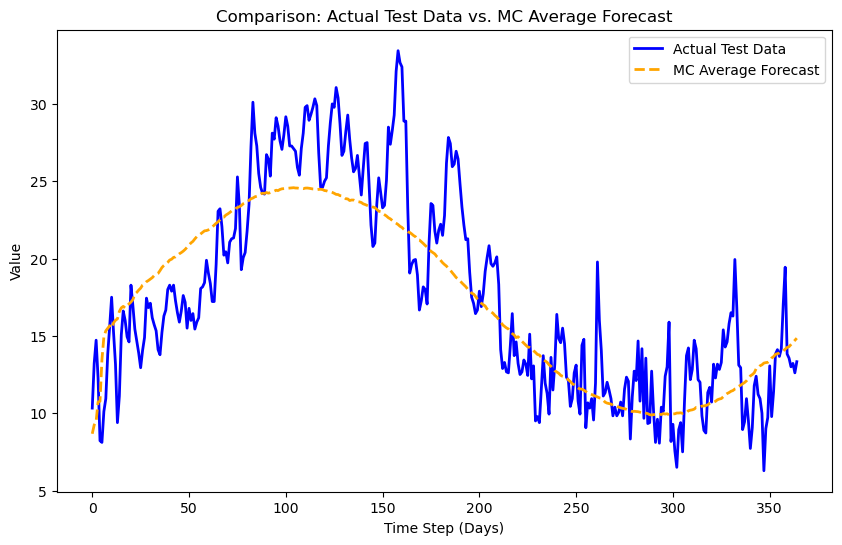

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

n_paths = 10000   # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path  # Debugging line to check random shocks
    print(f"Random shocks (eps) for path {t}: {eps}")  # Debugging line to check random shocks
    previous_value = T_all[:, t-1]

    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + forecast_df['k'].iloc[t] * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )
    
# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()

In [14]:
print(np.isnan(T_actual_test).sum())  # Number of NaNs in T_actual_test
print(np.isnan(T_avg).sum())          # Number of NaNs in T_avg

0
0


Mean Absolute Error (MAE): 1.3756082914508538
Mean Squared Error (MSE): 3.2597082330348424
Root Mean Squared Error (RMSE): 1.8054662093306655
Correlation Coefficient: 0.9614512516329173


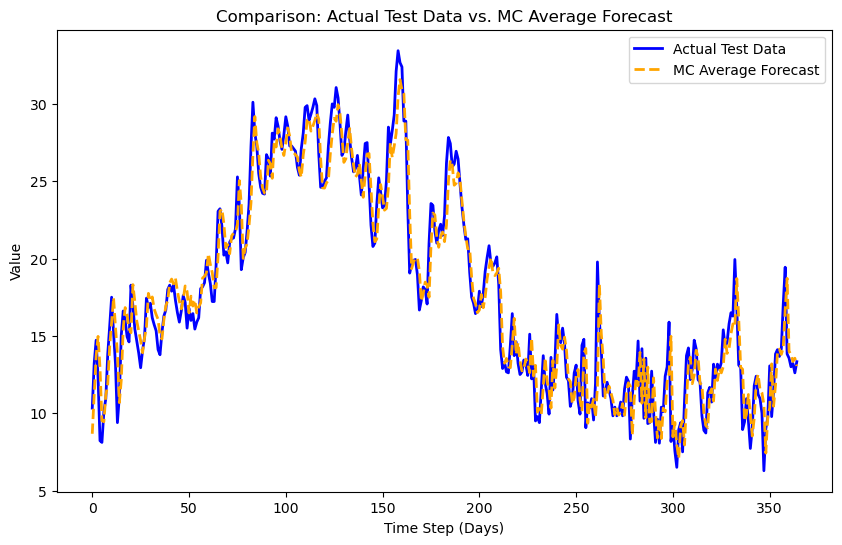

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

k = -0.1571                           # Fixed speed of mean reversion (a scalar)

n_paths = 1000000     # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    # Use the actual observed data at t-1 if available, otherwise fall back on the simulation
    if t-1 < len(T_actual_test):
        previous_value = T_actual_test[t-1]
    else:
        # If actual data is not available (e.g., beyond the test sample), you may use the forecasted average:
        previous_value = np.mean(T_all[:, t-1])
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + k * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()